## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [12]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random



print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [13]:
# Download MNIST
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)
# we get a special parameter while loading which is 'background'
#refer to document for what it means and how to use it

print(f"✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

✅ MNIST loaded: 60000 train, 10000 test images


In [14]:

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

task_definitions = {
     "A": [0, 1],
    "B": [2, 3],
    "C": [4, 5],
    "D": [6, 7],
    "E": [8, 9]
}

#Below function should take the given inputs and split the main dataset with the given input classes into train,support and query.
def create_task_datasets(dataset, task_classes, n_train=1000, n_support=5, n_query=10):
    class_to_indices = defaultdict(list)

    # Group indices by class
    for idx, (_, label) in enumerate(dataset):
        if label in task_classes:
            class_to_indices[label].append(idx)

    train_data, support_data, query_data = [], [], []

    for cls in task_classes:
        indices = class_to_indices[cls]
        random.shuffle(indices)

        train_idx = indices[:n_train]
        support_idx = indices[n_train:n_train + n_support]
        query_idx = indices[n_train + n_support:n_train + n_support + n_query]

        train_data += train_idx
        support_data += support_idx
        query_data += query_idx

    return (
        Subset(dataset, train_data),
        Subset(dataset, support_data),
        Subset(dataset, query_data)
    )


# TODO: Implement this function
# HINT: Filter dataset to only include examples from task_classes
# HINT: Split into train/support/query sets

In [15]:
# Test the function

train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'])
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 2000, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [16]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'


#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [18]:
def train_model(model, loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    accs = []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        epoch_loss = 0

        for x, y in loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        losses.append(epoch_loss)
        accs.append(correct / total)

    return losses, accs


def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total






In [19]:
#Method 1 - Fully Trained Binary Classifier on Task A
train_loader = DataLoader(train_A, batch_size=64, shuffle=True)
query_loader = DataLoader(query_A, batch_size=64)

model_m1 = SimpleCNN().to(device)
loss_m1, acc_m1 = train_model(model_m1, train_loader, epochs=10)


print("Method 1 Query Accuracy:",
      evaluate_model(model_m1, query_loader))


Method 1 Query Accuracy: 1.0


In [20]:
#Method 2 - Fine Tuning all 3 methods



#Random Init + Fine-tune
support_loader = DataLoader(support_A, batch_size=5, shuffle=True)

model_m21 = SimpleCNN().to(device)
loss_m21, acc_m21 = train_model(model_m21, support_loader, epochs=20)


print("Method 2.1 Query Accuracy:",
      evaluate_model(model_m21, query_loader))


#Pretrain on Task A → Fine-tune

model_m22 = SimpleCNN().to(device)
train_model(model_m22, train_loader, epochs=10)
loss_m22, acc_m22 = train_model(model_m22, support_loader, epochs=10)


print("Method 2.2 Query Accuracy:",
      evaluate_model(model_m22, query_loader))




#Pretrain on ALL DIGITS (10-class)
model_10 = SimpleCNN(num_classes=10).to(device)
full_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

train_model(model_10, full_loader, epochs=5)


model_m23 = SimpleCNN().to(device)
model_m23.features.load_state_dict(model_10.features.state_dict())
loss_m23, acc_m23 = train_model(model_m23, support_loader, epochs=10)


print("Method 2.3 Query Accuracy:",
      evaluate_model(model_m23, query_loader))



Method 2.1 Query Accuracy: 1.0
Method 2.2 Query Accuracy: 1.0
Method 2.3 Query Accuracy: 1.0


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

In [21]:
#Analysis and Plots

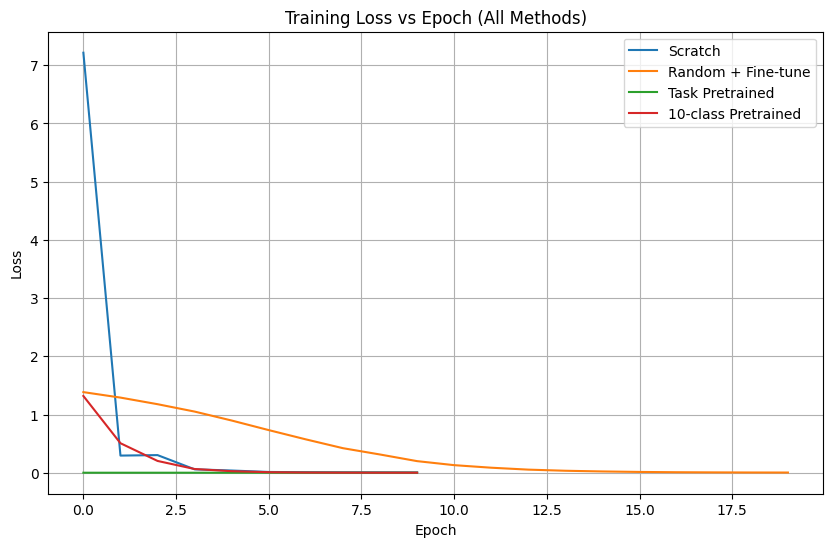

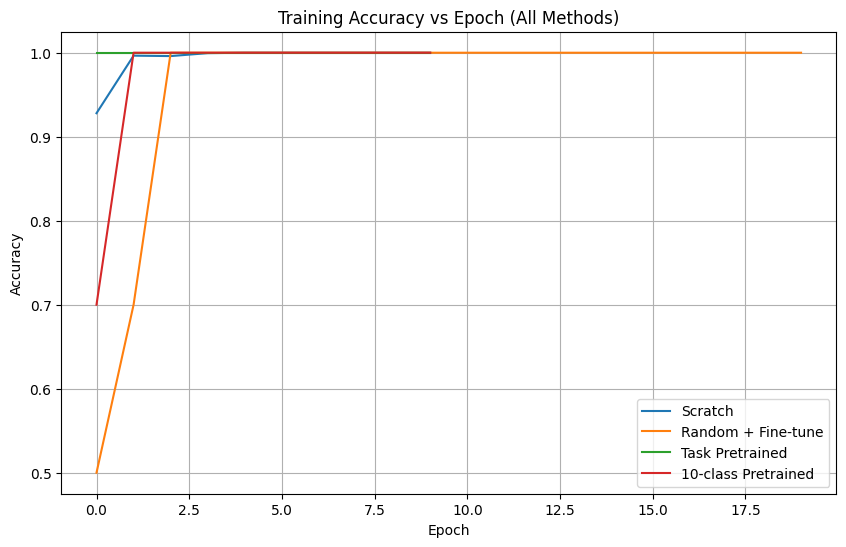

Method                    | Acc | Prec | Recall | F1
-----------------------------------------------------------------
Scratch                   | 1.000 | 1.000 | 1.000 | 1.000
Random + FT               | 1.000 | 1.000 | 1.000 | 1.000
Task Pretrained           | 1.000 | 1.000 | 1.000 | 1.000
10-class Pretrained       | 1.000 | 1.000 | 1.000 | 1.000


In [22]:
#Learning Curve (LOSS vs Epoch)
plt.figure(figsize=(10,6))

plt.plot(loss_m1, label="Scratch")
plt.plot(loss_m21, label="Random + Fine-tune")
plt.plot(loss_m22, label="Task Pretrained")
plt.plot(loss_m23, label="10-class Pretrained")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch (All Methods)")
plt.legend()
plt.grid(True)
plt.show()



#Learning Curve (ACCURACY vs Epoch)

plt.figure(figsize=(10,6))

plt.plot(acc_m1, label="Scratch")
plt.plot(acc_m21, label="Random + Fine-tune")
plt.plot(acc_m22, label="Task Pretrained")
plt.plot(acc_m23, label="10-class Pretrained")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Epoch (All Methods)")
plt.legend()
plt.grid(True)
plt.show()


#Proper Query-Set Metrics

def compute_metrics(model, loader):
    TP = FP = TN = FN = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)

            TP += ((preds == 1) & (y == 1)).sum().item()
            TN += ((preds == 0) & (y == 0)).sum().item()
            FP += ((preds == 1) & (y == 0)).sum().item()
            FN += ((preds == 0) & (y == 1)).sum().item()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return accuracy, precision, recall, f1



#Comparison Table

models = {
    "Scratch": model_m1,
    "Random + FT": model_m21,
    "Task Pretrained": model_m22,
    "10-class Pretrained": model_m23
}

print(f"{'Method':25s} | Acc | Prec | Recall | F1")
print("-"*65)

for name, model in models.items():
    acc, p, r, f1 = compute_metrics(model, query_loader)
    print(f"{name:25s} | {acc:.3f} | {p:.3f} | {r:.3f} | {f1:.3f}")


Some Theoritical Questions :

---



1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



Answers

Q1.

Because lower CNN layers learn general digit features transferable across tasks.

Q2.

Only small weight adjustments are needed → fast convergence.

Q3.

Representation learning: features ≠ classifier.

Q4.
Not explicitly.
But we simulated the goal of MAML: good initialization.

# ALL THE BEST !